In [1]:
from flow_package.multi_flow_env import MultipleFlowEnv, InputType
import flow_package as f_p
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from glob import glob
import dask.dataframe as dd
import gc
# 必要なインポートを追加
import seaborn as sns

CONST = f_p.Const()

In [2]:

# TRAIN_PATH = os.path.abspath("../../raw_after_filtered/cicids2017/data/Benign-Monday-WorkingHours.pcap_ISCX.csv_0.csv")
# TEST_PATH = os.path.abspath("../../raw_after_filtered/cicids2017/data/Benign-Monday-WorkingHours.pcap_ISCX.csv_1.csv")

# train_data = pd.read_csv(TRAIN_PATH)
# test_data = pd.read_csv(TEST_PATH)

TRAIN_DIR = os.path.abspath("../../raw_after_filtered/cicids2017/data")
paths = glob(os.path.join(TRAIN_DIR, "*.csv"))

df = pd.DataFrame()
for path in paths:
    print(f"\r{path}", end="")
    df = pd.concat([df, pd.read_csv(path, dtype=CONST.dtypes)])
print()

df = df.dropna(how="any").dropna(axis=1, how="any")
df = df.drop(columns=["Unnamed: 0"]).drop_duplicates()

test_data = df[df["Number Label"] != 0]

TRAIN = "../../hybrid_sample.csv"
path = os.path.abspath(TRAIN)
train_data = pd.read_csv(path).drop(columns=["Unnamed: 0"]).drop_duplicates()

del df
gc.collect()

/Users/toshi_pro/Documents/github-sub/drl/raw_after_filtered/cicids2017/data/Benign-Monday-WorkingHours.pcap_ISCX.csv_003.csv_002.csv.csvsv.csv


20

In [3]:
test_data["Number Label"].value_counts()

Number Label
11    171987
1     128011
8      90694
12     10266
5       5931
9       5363
10      5226
6       3153
7       1944
2       1427
3        652
14        36
4         20
13        11
Name: count, dtype: int64

In [4]:
print(train_data["Number Label"].value_counts())

smote = SMOTENC(categorical_features=["Protocol", "Destination Port"],random_state=42, sampling_strategy="auto", k_neighbors=3)
x_smote, y_smote = smote.fit_resample(
    train_data.drop(columns=["Number Label"]), train_data["Number Label"]
)
train_data = pd.concat([x_smote, y_smote], axis=1)
print(train_data["Number Label"].value_counts())

Number Label
14    5796
1     5796
13    5796
3     5796
4     5795
12    5791
0     5762
7     5745
2     5716
8     5611
10    5521
9     5365
11    4499
5     4441
6     3100
Name: count, dtype: int64


/Users/toshi_pro/Documents/github-sub/drl/.venv/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/toshi_pro/Documents/github-sub/drl/.venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Number Label
14    5796
10    5796
6     5796
7     5796
0     5796
4     5796
11    5796
1     5796
12    5796
5     5796
9     5796
2     5796
13    5796
8     5796
3     5796
Name: count, dtype: int64


In [5]:
train_input = InputType(
    input_features=train_data.drop(columns=["Number Label"]),
    input_labels=train_data["Number Label"],
    reward_list=[1.0, -1.0],
    type_env=None
)
train_env = MultipleFlowEnv(train_input)

test_input = InputType(
    input_features=test_data.drop(columns=["Number Label"]),
    input_labels=test_data["Number Label"],
    reward_list=[1.0, -1.0],
    type_env="test"
)
test_env = MultipleFlowEnv(test_input)

In [6]:
import matplotlib
import random

from collections import deque, namedtuple
from itertools import count

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import torch.optim as optim

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [7]:
device_name = "cpu"

if False:
    if torch.cuda.is_available():
        device_name = "cuda"
    elif torch.mps.is_available():
        device_name = "mps"
    # elif torch.hip.is_available():
    #     device_name = "hip"
    elif torch.mtia.is_available():
        device_name = "mtia"
    elif torch.xpu.is_available():
        device_name = "xpu"

device = torch.device(device_name)
print(f"device: {device_name}")

device: cpu


In [8]:
Transaction = namedtuple('Transaction', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        # self.capacity = capacity
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transaction(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [9]:
def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

def plot_graph(data: list, show_result=False):
    plt.figure(figsize=(15,5))
    # durations_t = torch.tensor(episode_durations, dtype=torch.float)

    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    
    means = moving_average(data, 200)
    lines = np.full(len(means), 1/15)

    first = len(data) - len(means)
    if first < 0:
        first = 0
    else:
        means = np.concatenate((np.full(first, np.nan), means))
        lines = np.concatenate((np.full(first, np.nan), lines))

    plt.plot(lines, color="blue", linestyle="--")

    plt.xlabel("Episode")
    plt.ylabel("ratio")
    # plt.plot(data, color="purple", alpha=0.5)
    plt.plot(means, color="red")
    plt.grid()

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [10]:
def plot_normal_graph(data: list, show_result=False):
    plt.figure(figsize=(15,5))
    # durations_t = torch.tensor(episode_durations, dtype=torch.float)

    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    
    means = moving_average(data, 200)

    plt.xlabel("Step")
    plt.ylabel("Loss")
    # plt.plot(data, color="purple")
    plt.plot(means, color="red")
    plt.grid()

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [11]:
def plot_metrics(metrics_dict: dict, show_result=False):
    fig = plt.figure(figsize=(16, 20))

    ac = fig.add_subplot(5, 1, 1)
    ac.plot(metrics_dict["accuracy"], label="accuracy")
    ac.grid()
    ac.set_title("Accuracy")

    pr = fig.add_subplot(5, 1, 2)
    pr.plot(metrics_dict["precision"], label="precision", color="green")
    pr.grid()
    pr.set_title("Precision")

    re = fig.add_subplot(5, 1, 3)
    re.plot(metrics_dict["recall"], label="recall", color="red")
    re.grid()
    re.set_title("Recall")

    f1 = fig.add_subplot(5, 1, 4)
    f1.plot(metrics_dict["f1"], label="f1", color="black")
    f1.grid()
    f1.set_title("F1")

    fpr = fig.add_subplot(5, 1, 5)
    fpr.plot(metrics_dict["fpr"], label="fpr", color="purple")
    fpr.grid()
    fpr.set_title("FPR")

    plt.tight_layout()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def calculate_metrics(tp, tn, fp, fn):
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if tp + fp != 0 else -1
    recall = tp / (tp + fn) if tp + fn != 0 else -1
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else None
    fpr = fp / (fp + tn) if fp + tn != 0 else None

    if precision < 0:
        precision = None
    if recall < 0:
        recall = None
    return accuracy, precision, recall, f1, fpr

In [12]:
PORT_DIM = 32
class DeepFlowNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DeepFlowNetwork, self).__init__()

        self.protocol_embedding = nn.Embedding(256, 8) # -> 8
        self.port_embedding = nn.Embedding(65536, PORT_DIM) # -> 8
        # other inputs are not embedding: n_inputs - 2

        # all inputs: n_inputs - 2 + 8 + 8 = n_inputs + 14
        n_inputs = n_inputs + 6 + PORT_DIM

        self.fc1 = nn.Linear(n_inputs, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, n_outputs)

    def forward(self, x):
        port_emb = self.port_embedding(x[0].long())
        protocol_emb = self.protocol_embedding(x[1].long())

        # print(port_emb.shape, protocol_emb.shape, x[2].shape)

        renew = torch.cat([port_emb, protocol_emb, x[2]], dim=1)

        renew = F.relu(self.fc1(renew))
        renew = F.relu(self.fc2(renew))
        return self.fc3(renew)

In [13]:
UPDATE_TARGET_STEPS = 200
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100000
TAU = 0.005
LR = 1e-4

In [14]:
REWARD_MATRIX = np.array([
    [ 3., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
    [-1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 0.,  0.],
    [-1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 0.,  0.],
    [-1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 0.,  0.],
    [-1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 0.,  0.],
    [-1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 0.,  0.],
    [-1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0., 0.,  0.],
    [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0., 0.,  0.],
    [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0., 0.,  0.],
    [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0., 0.,  0.],
    [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0., 0.,  0.],
    [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0., 0.,  0.],
    [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2., 0.,  0.],
    [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 2.,  0.],
    [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 0.,  2.]
  ])


def get_reward(action, answer):
    return REWARD_MATRIX[action, answer]

In [23]:
num_episodes = 8000

In [ ]:
n_actions = train_env.action_space.n
n_inputs = train_env.observation_space.shape[0]

# print(f"n_inputs: {n_inputs}, n_actions: {n_actions}")

state = train_env.reset()
# print(info)

policy_net = DeepFlowNetwork(n_inputs, n_actions).to(device)
target_net = DeepFlowNetwork(n_inputs, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
steps_done = 0

memory = ReplayMemory(10000)
episode_rewards = []
episode_precision = []
loss_array = []

with open("train.log", "w") as f:
    f.write("episode, show\n")


In [17]:
def select_action(state_tensor: torch.Tensor):
    # print(f"state_tensor: {state_tensor[0,1]}")
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            # print(policy_net(state_tensor))
            # print(policy_net(state_tensor).max(1))
            return policy_net(state_tensor).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long, device=device)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transaction(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool
    )
    # non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    # print(batch.state[0])
    state_batch_port = torch.cat([s[0] for s in batch.state])
    state_batch_protocol = torch.cat([s[1] for s in batch.state])
    state_batch_other = torch.cat([s[2] for s in batch.state])

    state_batch = [state_batch_port, state_batch_protocol, state_batch_other]
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # non_final_next_states も同様に処理
    non_final_next_states_port = torch.cat([s[0] for s in batch.next_state if s is not None])
    non_final_next_states_protocol = torch.cat([s[1] for s in batch.next_state if s is not None])
    non_final_next_states_features = torch.cat([s[2] for s in batch.next_state if s is not None])
    non_final_next_states = [non_final_next_states_port, non_final_next_states_protocol, non_final_next_states_features]
    
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = reward_batch + GAMMA * next_state_values

    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    utils.clip_grad_value_(policy_net.parameters(), 1000)
    optimizer.step()
    return loss.item()

<Figure size 640x480 with 0 Axes>

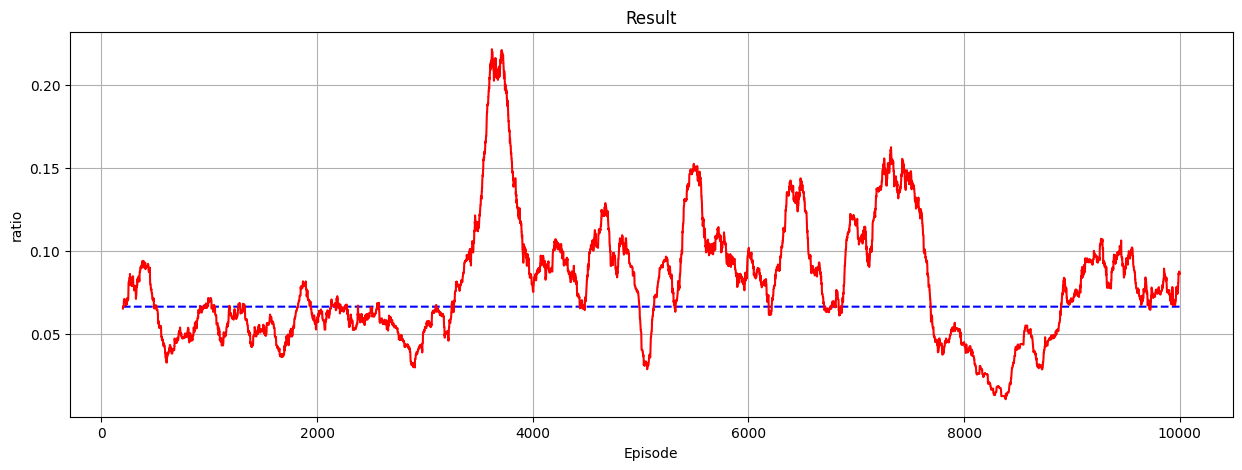

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

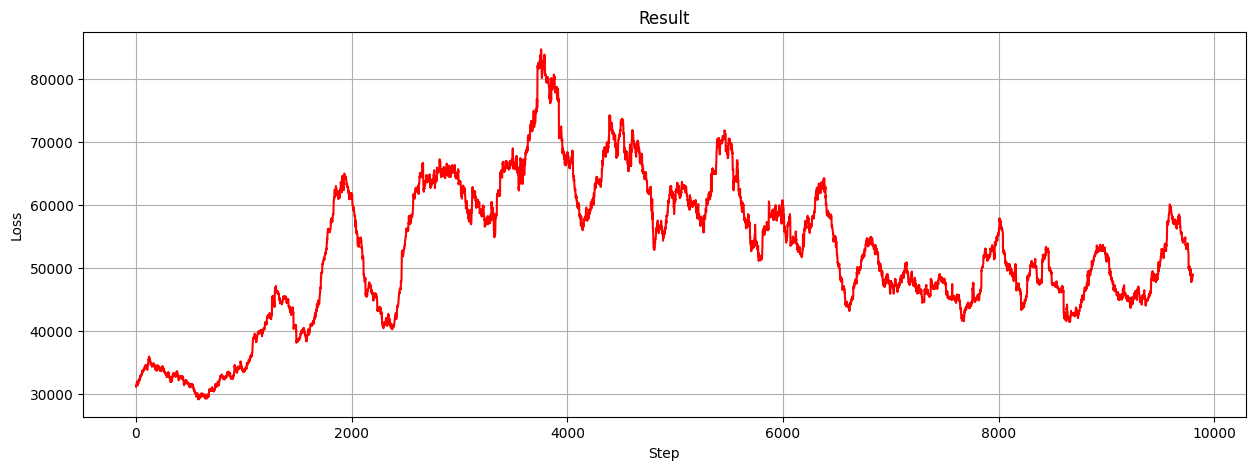

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
for i_episode in range(num_episodes):
    test = []
    # Initialize the environment and state
    random.seed(i_episode)
    sum_reward = 0
    confusion_matrix = np.zeros((2,2), dtype=int)

    initial_state = train_env.reset()
    # state = torch.tensor(initial_state, device=device, dtype=torch.float32).unsqueeze(0)
    state = f_p.to_tensor(initial_state)

    show = np.zeros(n_actions, dtype=int)
    for t in count():
        # select action
        action = select_action(state)

        # print(action)
        # calculate next state
        raw_next_state, reward, terminated, truncated, info = train_env.step(action.item())
        row_column_index = info["matrix_position"]
        confusion_matrix[row_column_index[0], row_column_index[1]] += 1
        test.append(info["answer"])
        show[action.item()] += 1
        # print(info)
        reward = get_reward(info["action"], info["answer"])

        # to tensor
        if terminated:
            with open("train.log", "a") as f:
                f.write(f"{i_episode}, {show}\n")
            next_state = None
        else:
            # next_state = torch.tensor(raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)
            next_state = f_p.to_tensor(raw_next_state)
        reward = torch.tensor([reward], device=device, dtype=torch.float32)

        # store the transition in memory
        memory.push(state, action, next_state, reward)
        sum_reward += reward.item() if reward.item() == 1 else 0

        # move to the next state
        state = next_state

        # optimize the model
        # print("optimize_model")
        loss = optimize_model()

        # print(f"\r{pd.Series(test).std():03f}", end="")
        if terminated:
            loss_array.append(loss)
            episode_rewards.append(sum_reward / (t + 1))
            break

    # do after the episode
    # episode_rewards.append(sum_reward)
    base = confusion_matrix[1, 1] + confusion_matrix[1, 0]
    episode_precision.append(
        confusion_matrix[1, 1] / base if base != 0 else 0
    )
    # print(pd.Series(test).std(), show.std())
    # with open(f"train/training_{i_episode}.csv", "a") as f:
    #     for i in test:
    #         f.write(f"{i:02d},")
    #     else:
    #         f.write("\n")
    if i_episode > 0 and i_episode % 5 == 0:
        # plot_graph(episode_precision)
        # plot_graph(loss_array)
        plot_normal_graph(np.array(loss_array))

# complete the episode
plot_graph(episode_precision, show_result=True)
plot_normal_graph(loss_array, show_result=True)
torch.save(policy_net.state_dict(), "re_01_dqn_cic.pth")  # save the model

# print(test)
train_env.close()

In [19]:
def plot_confusion_matrix(confusion_array, class_names=None, show_result=False):
    """
    混同行列をヒートマップとして表示する関数
    
    Parameters:
    -----------
    confusion_array : numpy.ndarray
        表示する混同行列
    class_names : list, optional
        クラス名のリスト。指定しない場合はインデックスが使用される
    """

    plt.figure(figsize=(10, 8))
    
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title(f"Testing...")

    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(confusion_array))]
    
    conf_matrix = confusion_array.copy().astype(float)
    
    for column in range(n_actions):
        sum_column = 0
        for row in range(n_actions):
            sum_column += conf_matrix[row][column]
        if sum_column == 0:
            continue
        for row in range(n_actions):
            conf_matrix[row][column] /= sum_column
            
    
    # ヒートマップの作成
    sns.heatmap(
        conf_matrix, 
        annot=True, 
        cmap='Blues',
        fmt=".0%",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    
    # 軸ラベルの方向を修正
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    plt.tight_layout()
    plt.grid()

    plt.pause(0.1)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

[0, 0, 0, 0, 0, 0, 0, 0, 703, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 79423, 531, 124, 10, 5898, 3136, 146, 35230, 3142, 4001, 46100, 6245, 11, 33],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 12426, 0, 0, 0, 0, 0, 0, 0, 0, 19, 13537, 330, 0, 0],
[0, 5, 0, 0, 0, 32, 14, 0, 451, 34, 28, 29913, 2, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 1291, 36873, 0, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 462, 0, 0, 3506, 19, 0, 0],
[0, 24474, 75, 4, 8, 0, 0, 0, 2226, 6, 339, 70047, 3656, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 11683, 821, 524, 2, 1, 0, 507, 13107, 2181, 838, 8564, 14, 0, 0],
[0, 0, 0, 0, 0, 0, 3, 0, 1642, 0, 0, 0, 0, 0, 3],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 319, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],


<Figure size 640x480 with 0 Axes>

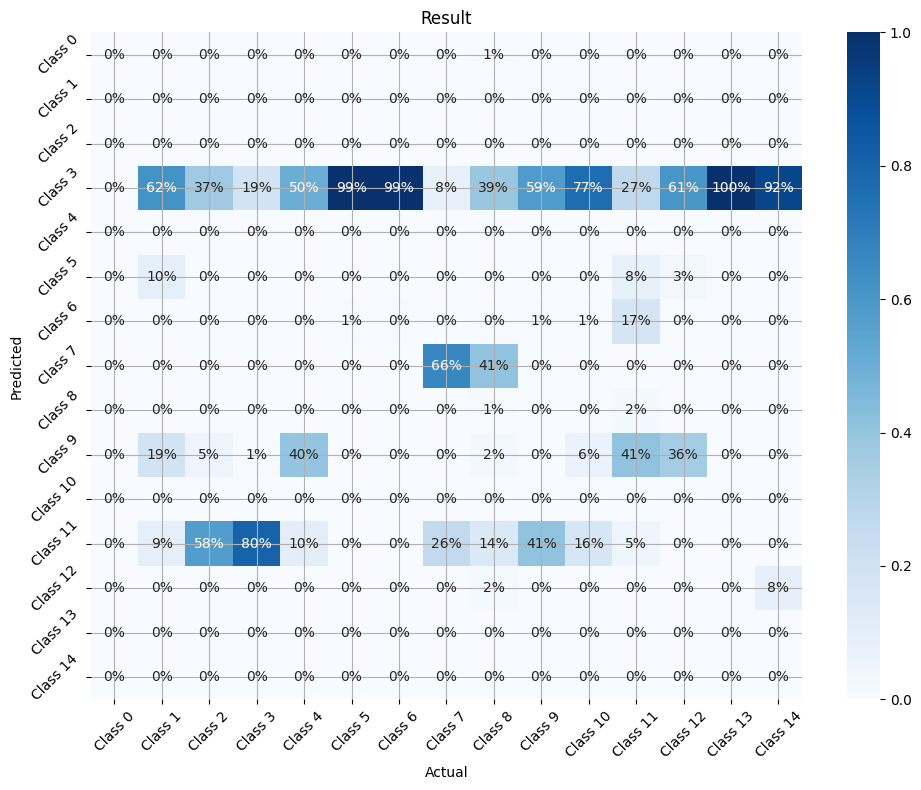

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [25]:
MODEL_PATH = "re_01_dqn_cic.pth"

# load the model
trained_network = DeepFlowNetwork(n_inputs=n_inputs, n_outputs=n_actions).to(device)
trained_network.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
trained_network.eval()

# test the model
counts = test_data["Number Label"].value_counts()

confusion_array = np.zeros(
    (n_actions, n_actions),
    dtype=np.int32
)

metrics_dictionary = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "fpr": []
}

for i_loop in range(1):
    random.seed(i_loop)
    test_raw_state = test_env.reset()
    try:
        test_state = f_p.to_tensor(test_raw_state)
    except:
        raise print(test_raw_state)
    
    for t in count():
        with torch.no_grad():
            test_action = trained_network(test_state).max(1).indices.view(1, 1)

        test_raw_next_state, test_reward, test_terminated, test_truncated, test_info = test_env.step(test_action.item())
        # print(test_info)

        # calculate confusion matrix
        raw = 0 if test_reward == 1 else 1

        # test_info = (row, column) means confusion matrix index
        action = test_info["action"]
        answer = test_info["answer"]
        confusion_array[action, answer] += 1

        # print(index)

        if test_terminated:
            break

        # make next state tensor and update state
        #test_state = torch.tensor(test_raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)
        test_state = f_p.to_tensor(test_raw_next_state)

        if t % 100000 == 0:
            plot_confusion_matrix(confusion_array)

for i in range(n_actions):
    print("[", end="")
    for j in range(n_actions):
        if j == n_actions - 1:
            print(confusion_array[i, j], end="")
        else:
            print(confusion_array[i, j], end=", ")
    print("],")

plot_confusion_matrix(confusion_array, show_result=True)